In [2]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import scanorama
import scgen

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
import dynchro
from dynchro.tl import skip_dtw, skip_traceback

# Load data

In [10]:
d1 = ad.read_h5ad("data/dataseta0_processed.h5ad")
d2 = ad.read_h5ad("data/datasetb0_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

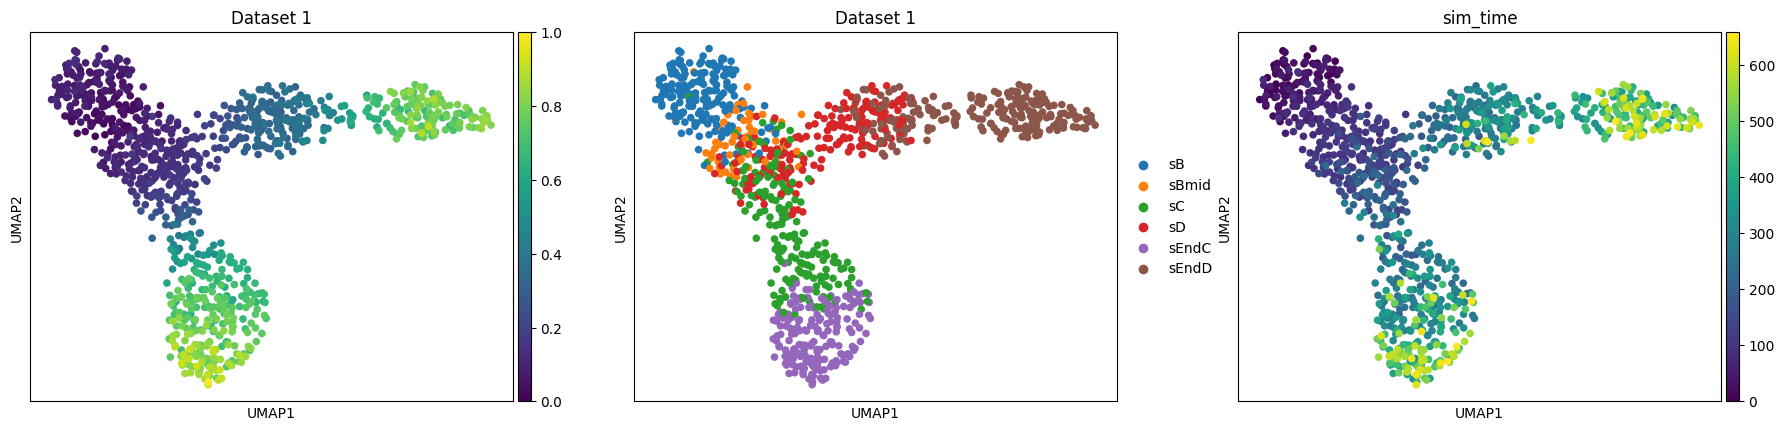

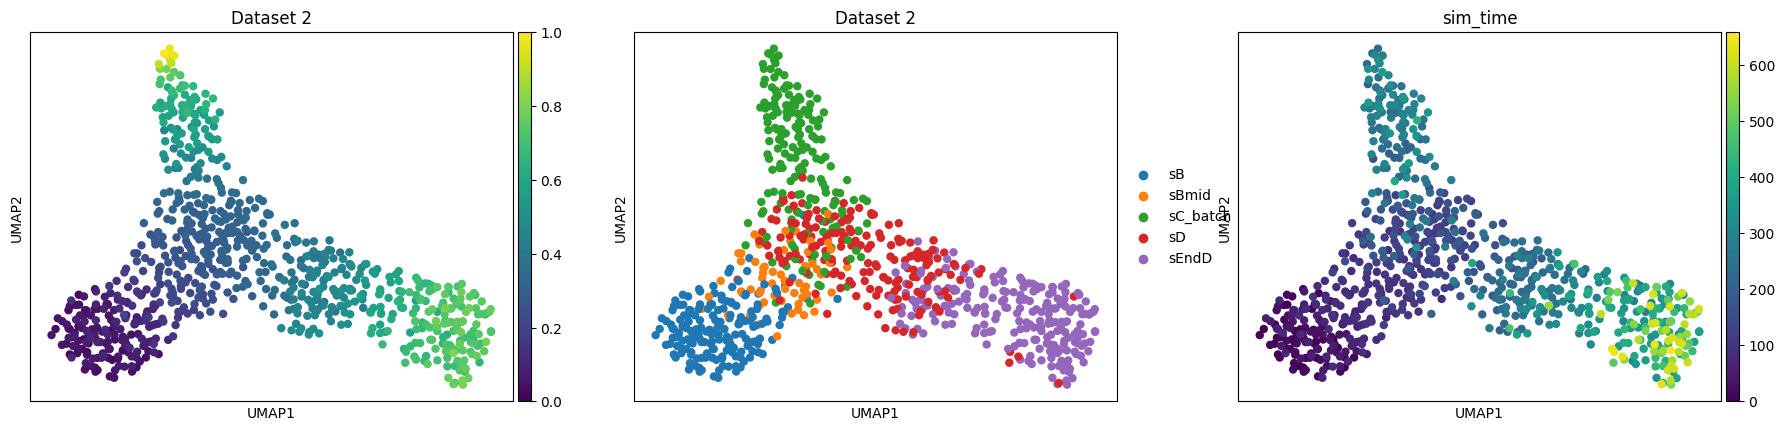

In [64]:
sc.pl.umap(d1, color = [ "dpt_pseudotime", "milestones", "sim_time"], title=["Dataset 1", "Dataset 1"])
sc.pl.umap(d2, color = [ "dpt_pseudotime", "milestones", "sim_time"], title=["Dataset 2", "Dataset 2"])

# Experiments

Here we use the top-performing trajectory conservation methods as shown in https://doi.org/10.1038/s41592-021-01336-8, scanorama, scGen and fastMNN

## Scanorama

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


In [65]:
d1.X = d1.X.todense()
d2.X = d2.X.todense()

adatas_cor = scanorama.correct_scanpy(
    [d1, d2],
    return_dimred = True,
)

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


Found 531 genes among all datasets
[[0.           0.9817518248]
 [0.           0.          ]]
Processing datasets (0, 1)


In [72]:
adata_scanorama = sc.concat(
    {"control": adatas_cor[0], "premature stop": adatas_cor[1]},
    label="batch",
    uns_merge="unique",
    index_unique="-",
)

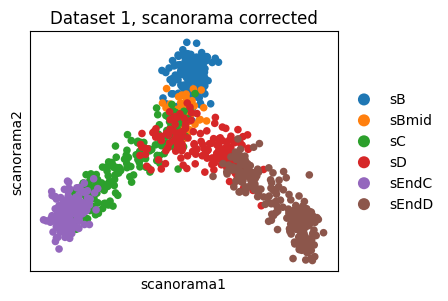

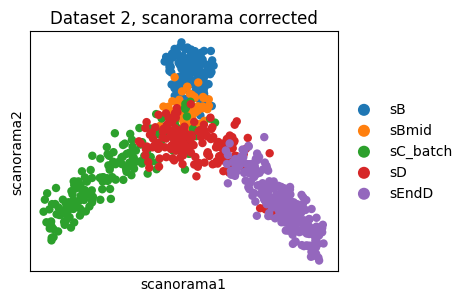

In [69]:
with plt.rc_context(rc={"figure.figsize": (4, 3)}):
    sc.pl.scatter(adatas_cor[0], basis="scanorama", color="milestones", title="Dataset 1, scanorama corrected")
    sc.pl.scatter(adatas_cor[1], basis="scanorama", color="milestones", title="Dataset 2, scanorama corrected")

<Axes: xlabel='x', ylabel='y'>

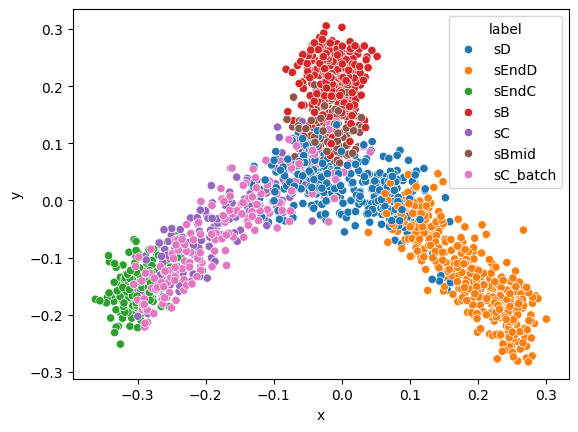

In [70]:
xvals = np.concat((adatas_cor[0].obsm["X_scanorama"][:, 0] ,adatas_cor[1].obsm["X_scanorama"][:, 0]))
yvals = np.concat((adatas_cor[0].obsm["X_scanorama"][:, 1] ,adatas_cor[1].obsm["X_scanorama"][:, 1]))
cats = np.concat((adatas_cor[0].obs["milestones"].values ,adatas_cor[1].obs["milestones"].values))

# create a DataFrame for the legend
legend_df = pd.DataFrame({
    "x": xvals,
    "y": yvals,
    "label": cats,
})

sns.scatterplot(
    data=legend_df,
    x="x",
    y="y",
    hue="label",
    legend=True,
)


### visualisation

In [74]:
del adata_scanorama.obsm["X_diffmap"]

In [75]:
sc.pp.neighbors(adata_scanorama, use_rep="X_scanorama")

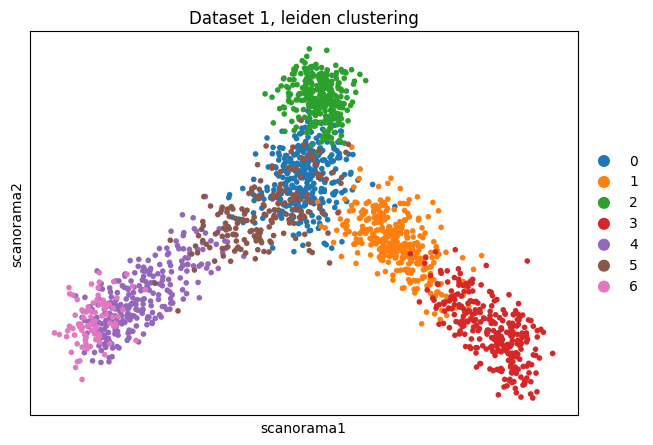

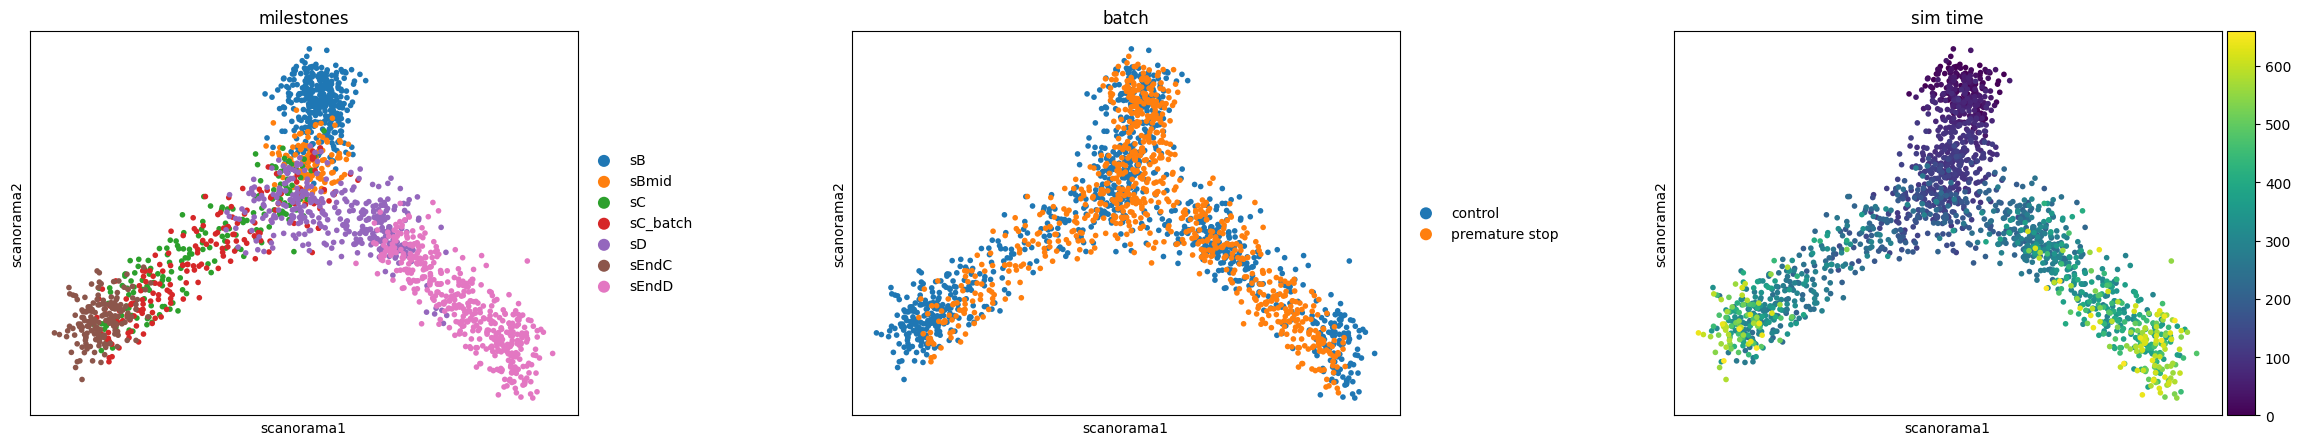

In [76]:
sc.tl.leiden(adata_scanorama, resolution=1.75, key_added="leiden1.75")
sc.pl.scatter(adata_scanorama, basis="scanorama", color='leiden1.75', title="Dataset 1, leiden clustering")
sc.pl.scatter(adata_scanorama, basis="scanorama", color=['milestones', 'batch', 'sim_time'])

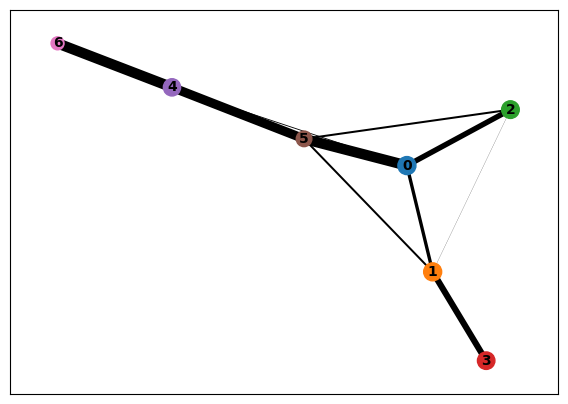

In [13]:
sc.tl.paga(adata_scanorama, groups="leiden1.75")
sc.pl.paga(adata_scanorama)

In [89]:
adata_scanorama[np.argmin(adata_scanorama.obs["sim_time"])].obs_names.values[0]

'cell24-control'

In [96]:
np.flatnonzero(adata_scanorama.obs["sim_time"] == 0.0)[0]

np.int64(23)

In [93]:
np.flatnonzero(adata_scanorama.obs["milestones"] == "sB")[0]

np.int64(6)

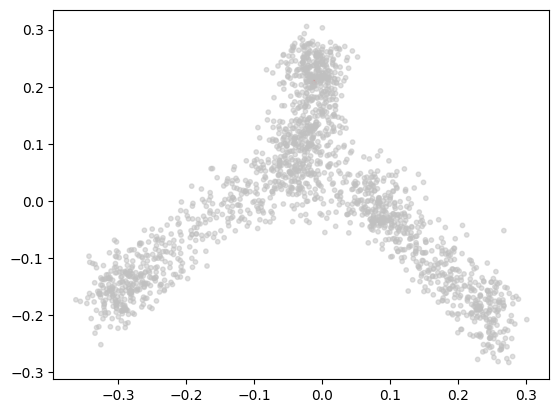

In [99]:
adata_scanorama.uns["iroot"] = np.flatnonzero(adata_scanorama.obs["sim_time"] == 0.0)[0] #np.flatnonzero(adata_scanorama.obs["milestones"] == "sB")[0]
plot_iroot(adata_scanorama)

In [100]:
sc.tl.dpt(adata_scanorama)

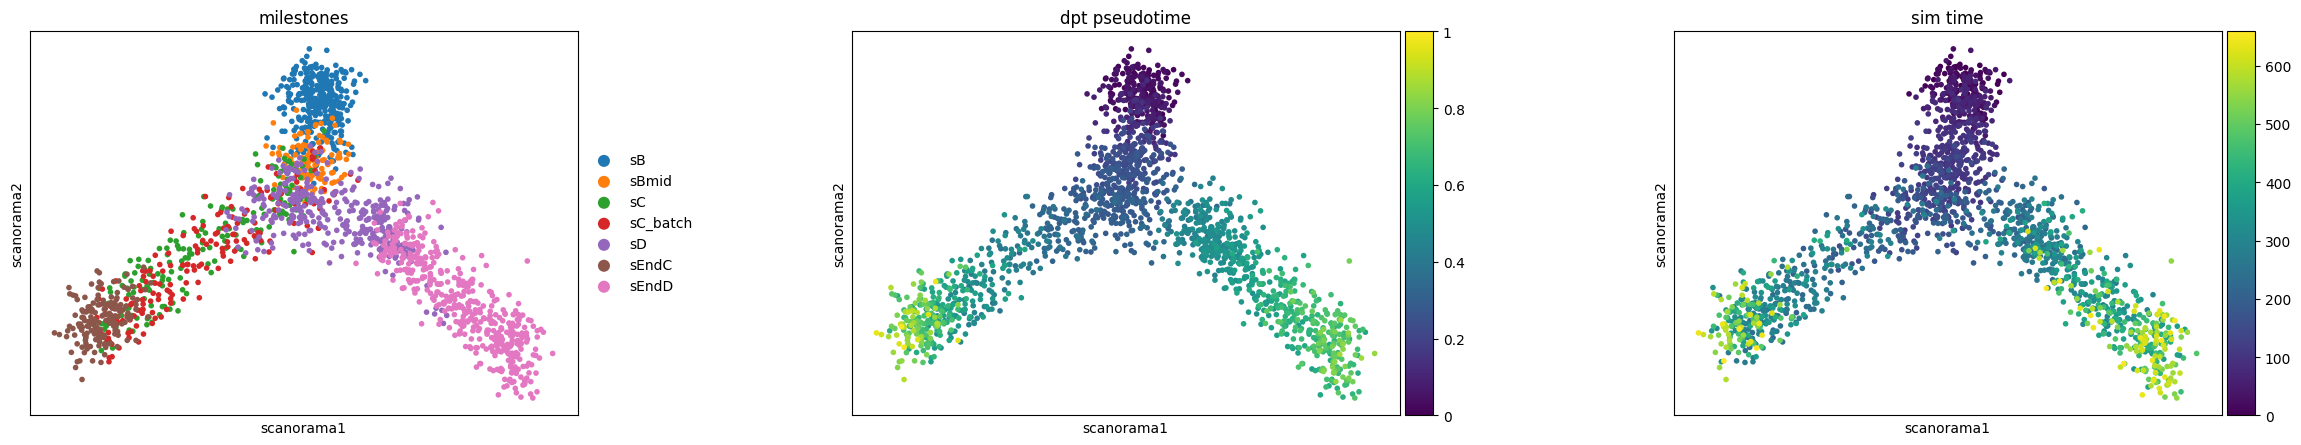

In [110]:
sc.pl.scatter(adata_scanorama, basis="scanorama", color=["milestones", "dpt_pseudotime", "sim_time"])

In [102]:
# select 2, 0, 5, 4, 6 from leiden1.75
scan_d1_l1 = adata_scanorama[adata_scanorama.obs["leiden1.75"].isin(["2", "0", "5", "4", "6"])]

# select 2, 0, 1, 3 from leiden1.75
scan_d2_l1 = adata_scanorama[adata_scanorama.obs["leiden1.75"].isin(["2", "0", "1", "3"])]

In [192]:
scgen_l2_1.obs.batch.cat.categories.values

array(['control', 'premature stop'], dtype=object)

In [212]:
def comp_kde(dataset, milestones, batches = None, milestone_column = "milestones", batch_column = "batch", time_column = "dpt_pseudotime", colors = None, title = None):
    """
    Function to plot the kernel density estimation of the data
    """
    if batches is None:
        batches = dataset.obs[batch_column].cat.categories.values
    if isinstance(milestones, str) or isinstance(milestones, int):
        milestones = [milestones] * len(batches)
    if colors is None:
        colors = [None] * len(batches)

    for batch, milestone, color in zip(batches, milestones, colors):
        dataset_batch = dataset[dataset.obs[batch_column] == batch]
        dataset_batch = dataset_batch[dataset_batch.obs[milestone_column] == milestone]

        sns.kdeplot(dataset_batch.obs[time_column], label=f"{batch} {milestone}", color=color, fill = True, alpha=0.5)

    plt.legend()
    plt.figure()

In [159]:
def kdeplot2(adata, batch, milestone, milestone_column = "milestones", time = "dpt_pseudotime", color=None):
    """
    Plot the kernel density estimate of the pseudotime for a given batch and milestone.
    """
    adata = adata[adata.obs[milestone_column] == milestone]
    adata = adata[adata.obs["batch"] == batch]
    sns.kdeplot(adata.obs[time], color=color, label=f"{batch} {milestone}", fill=True, alpha=0.5)

In [112]:
def kdeplot(adata, batch, milestone, time = "dpt_pseudotime", color=None):
    adata_mst = adata[adata.obs["milestones"] == milestone]
    adata_btc = adata_mst[adata_mst.obs["batch"] == batch]

    sns.kdeplot(adata_btc.obs[time], label=f"{batch} {milestone}", fill=True, alpha=0.5, color= color)

In [104]:
def plot_iroot(data):
    colormap_iroot = np.array(["#C0C0C0"] * data.n_obs)
    colormap_iroot[data.uns["iroot"]] = "#FF0000"

    plt.scatter(
        data.obsm["X_scanorama"][:, 0],
        data.obsm["X_scanorama"][:, 1],
        c=colormap_iroot,
        s=10,
        alpha=0.5,
    )

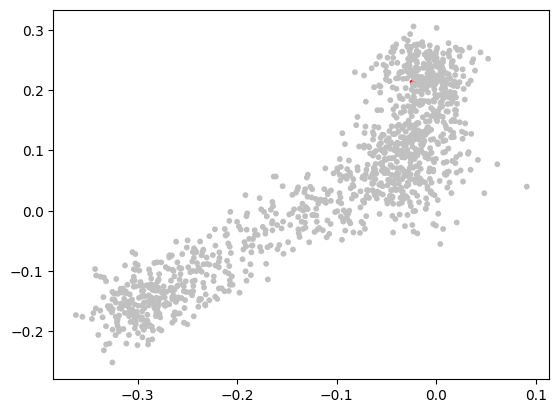

In [105]:
colormap_iroot = np.array(["#C0C0C0"] * scan_d1_l1.n_obs)
colormap_iroot[scan_d1_l1.uns["iroot"]] = "#FF0000"

plt.scatter(
    scan_d1_l1.obsm["X_scanorama"][:, 0],
    scan_d1_l1.obsm["X_scanorama"][:, 1],
    c=colormap_iroot,
    s=10,
)

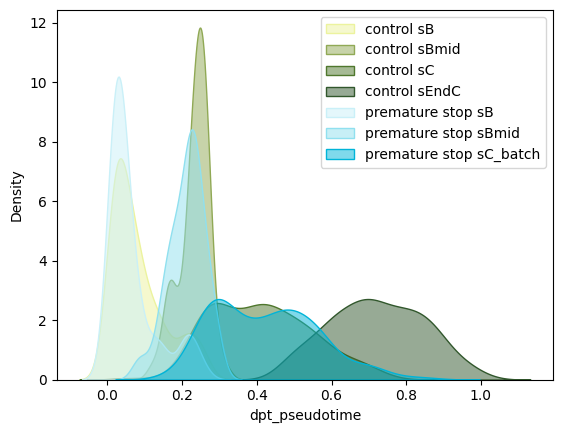

In [109]:
kdeplot(scan_d1_l1, "control", "sB", color= "#ecf39e")
kdeplot(scan_d1_l1, "control", "sBmid", color="#90a955")
kdeplot(scan_d1_l1, "control", "sC", color="#4f772d")
kdeplot(scan_d1_l1, "control", "sEndC", color="#31572c")
# kdeplot(scan_d1_l1, "control", "sD", color="#344e41")

plt.legend()
# plt.figure()

kdeplot(scan_d1_l1, "premature stop", "sB", color= "#caf0f8")
kdeplot(scan_d1_l1, "premature stop", "sBmid", color="#90e0ef")
kdeplot(scan_d1_l1, "premature stop", "sC_batch", color="#00b4d8")
# kdeplot(scan_d1_l1, "premature stop", "sD", color="#0077b6")
plt.legend()

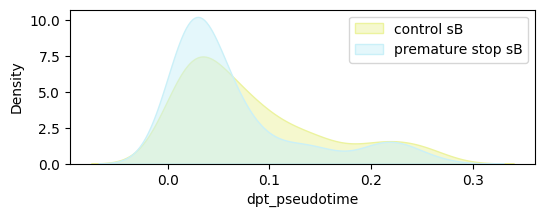

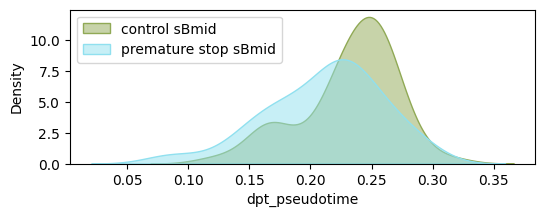

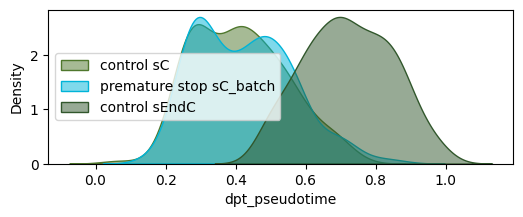

In [242]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(scan_d1_l1, "sB", colors = ["#ecf39e", "#caf0f8"])
    comp_kde(scan_d1_l1, "sBmid", colors = ["#90a955", "#90e0ef"])
    
    kdeplot2(scan_d1_l1, "control", "sC", milestone_column = "milestones", color="#4f772d")
    kdeplot2(scan_d1_l1, "premature stop", "sC_batch", milestone_column = "milestones", color="#00b4d8")
    kdeplot2(scan_d1_l1, "control", "sEndC", milestone_column = "milestones", color="#31572c")
    plt.legend()

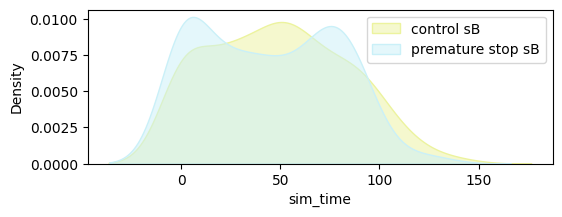

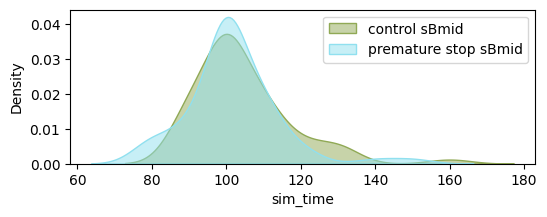

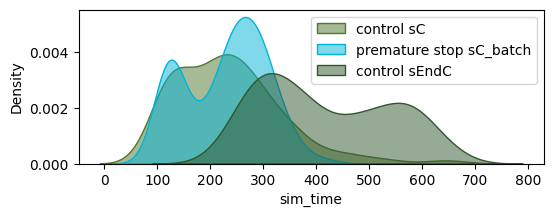

In [245]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(scan_d1_l1, "sB", colors = ["#ecf39e", "#caf0f8"], time_column="sim_time")
    comp_kde(scan_d1_l1, "sBmid", colors = ["#90a955", "#90e0ef"], time_column="sim_time")
    
    kdeplot2(scan_d1_l1, "control", "sC", milestone_column = "milestones", color="#4f772d", time="sim_time")
    kdeplot2(scan_d1_l1, "premature stop", "sC_batch", milestone_column = "milestones", color="#00b4d8", time="sim_time")
    kdeplot2(scan_d1_l1, "control", "sEndC", milestone_column = "milestones", color="#31572c",  time="sim_time")
    plt.legend()

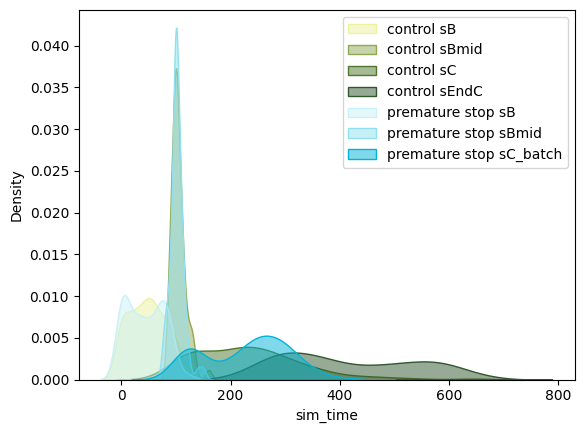

In [113]:
kdeplot(scan_d1_l1, "control", "sB", time="sim_time", color="#ecf39e")
kdeplot(scan_d1_l1, "control", "sBmid", time="sim_time", color="#90a955")
kdeplot(scan_d1_l1, "control", "sC", time="sim_time", color="#4f772d")
kdeplot(scan_d1_l1, "control", "sEndC", time="sim_time", color="#31572c")
# kdeplot(scan_d1_l1, "control", "sD", time="sim_time", color="#344e41")

plt.legend()
# plt.figure()

kdeplot(scan_d1_l1, "premature stop", "sB", time="sim_time", color="#caf0f8")
kdeplot(scan_d1_l1, "premature stop", "sBmid", time="sim_time", color="#90e0ef")
kdeplot(scan_d1_l1, "premature stop", "sC_batch", time="sim_time", color="#00b4d8")
# kdeplot(scan_d1_l1, "premature stop", "sD", time="sim_time", color="#0077b6")
plt.legend()


## scgen

In [30]:
datasets_mapping = {
    "control": d1,
    "premature stop": d2
}
datasets = ad.concat(datasets_mapping, label="batch")
datasets.obs_names_make_unique()

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [31]:
scgen.SCGEN.setup_anndata(datasets, batch_key="batch", labels_key="milestones")
model = scgen.SCGEN(datasets)

In [32]:
model.train(
    max_epochs=100,
    batch_size=16,
    early_stopping=True,
    early_stopping_patience=25,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1554.097. Signaling Trainer to stop.


In [33]:
corrected_adata = model.batch_removal()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/louise/Work/scgen/scgen/_scgen.py:265: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  batch_list[study].X = delta + batch_list[study].X
/home/louise/Work/scgen/scgen/_scgen.py:266: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  temp_cell[batch_ind[study]].X = batch_list[study].X
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indice

### Fix scgen

In [13]:
# FIXED IN https://github.com/LouiseDck/scgen or https://github.com/theislab/scgen/pull/104
# 
# import torch
# from torch import Tensor
# from torch.distributions import Distribution, Normal
# from torch.nn.functional import softmax

# from scvi.module._constants import MODULE_KEYS
# from scvi.dataloaders import AnnDataLoader

# dataloader = model._make_data_loader(
#     adata=datasets, indices=None, batch_size=None
# )
# print(len([x for x in dataloader]))
# print(MODULE_KEYS.QZM_KEY)

# zs: list[Tensor] = []
# qz_means: list[Tensor] = []
# qz_vars: list[Tensor] = []  
# for tensors in dataloader:
#     outputs: dict[str, Tensor | Distribution | None] = model.module.inference(
#         **model.module._get_inference_input(tensors)
#     )
#     print(outputs.keys())

#     if "qz" in outputs:
#         qz: Distribution = outputs.get("qz")
#         qzm: Tensor = qz.loc
#         qzv: Tensor = qz.scale.square()
#     else:
#         qzm: Tensor = outputs.get("qzm")
#         qzv: Tensor = outputs.get("qzv")
#         qz: Distribution = Normal(qzm, qzv.sqrt())
# 
#     z: Tensor = outputs.get("z")
#     zs.append(z.cpu())
# 
# latent = torch.cat(zs).detach().numpy()

### Plot data

In [34]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)


/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 531 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


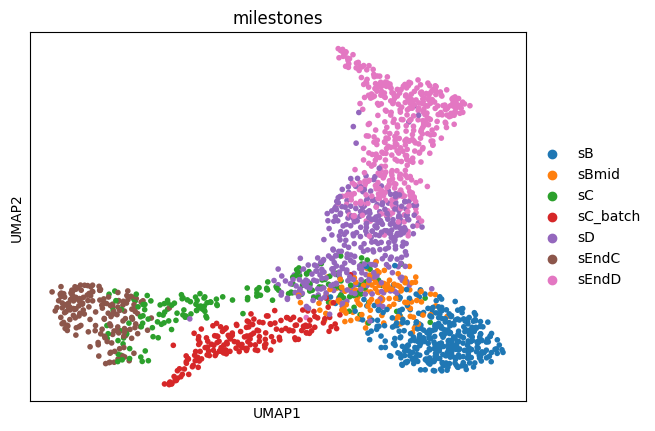

In [35]:
sc.pl.umap(corrected_adata, color='milestones', wspace=0.4)

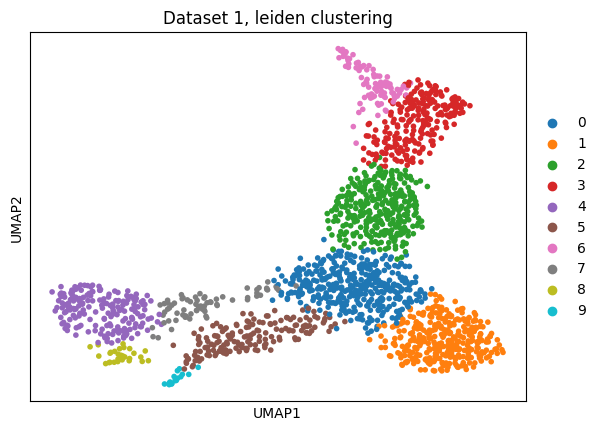

In [44]:
sc.tl.leiden(corrected_adata, resolution=1.5, key_added="leiden1.5")
sc.pl.umap(corrected_adata, color='leiden1.5', title="Dataset 1, leiden clustering")

In [45]:
sc.tl.paga(corrected_adata, groups="leiden1.5")

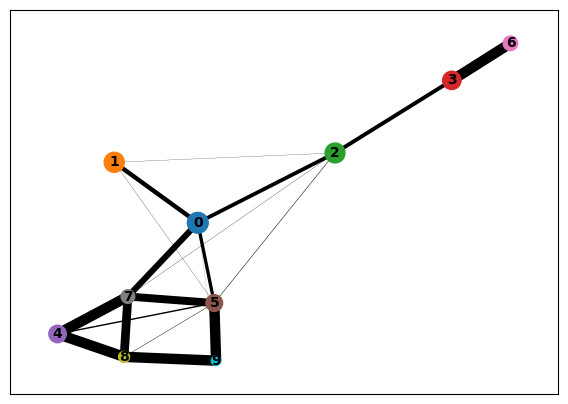

In [46]:
sc.pl.paga(corrected_adata)

In [49]:
# split into 2 datasets
# split on leiden1.5 1, 0, 2, 3, 6
scgen1_d1_l1 = corrected_adata[corrected_adata.obs["leiden1.5"].isin(["1", "0", "2", "3", "6"])]
# and on 1, 9, 4, 5, 7, 8, 9
scgen1_d2_l1 = corrected_adata[corrected_adata.obs["leiden1.5"].isin(["1", "9", "4", "5", "7", "8", "9"])]


In [48]:
corrected_adata.uns["iroot"] = np.flatnonzero(corrected_adata.obs["milestones"] == "sB")[0]
sc.tl.dpt(corrected_adata)


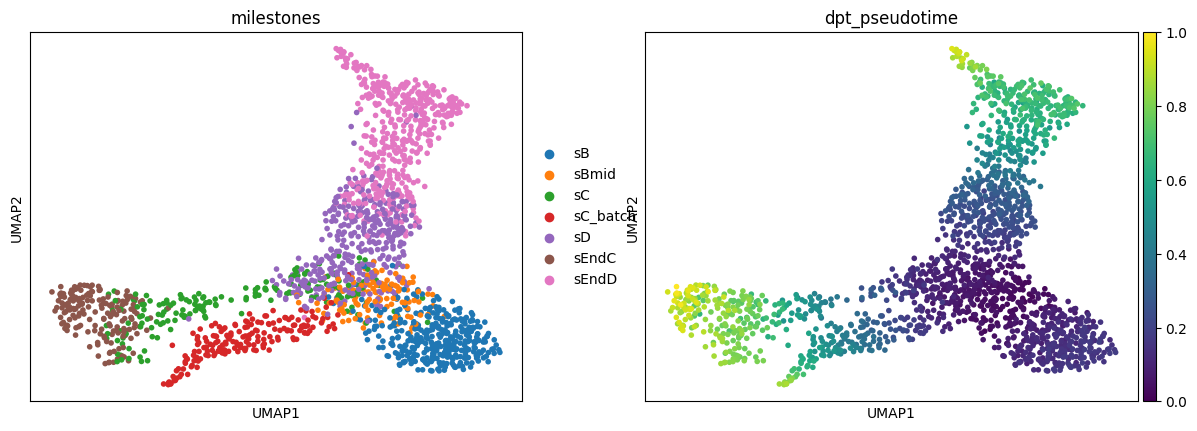

In [51]:
sc.pl.umap(corrected_adata, color=["milestones", "dpt_pseudotime"])

In [57]:
scgen1_d1_l1.obs["batch"]

cell1               control
cell2               control
cell3               control
cell4               control
cell7               control
                  ...      
cell994-1    premature stop
cell995-1    premature stop
cell997-1    premature stop
cell998-1    premature stop
cell999-1    premature stop
Name: batch, Length: 1353, dtype: category
Categories (2, object): ['control', 'premature stop']

/tmp/ipykernel_6473/761163714.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(adata_btc.obs["dpt_pseudotime"], label=f"{batch} {milestone}", fill=True, alpha=0.5, color= color)


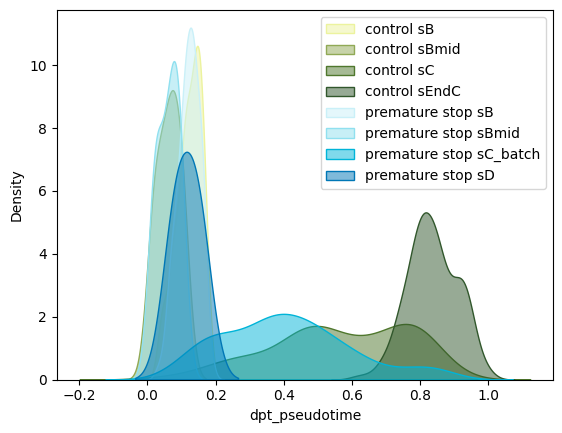

In [59]:
kdeplot(scgen1_d2_l1, "control", "sB", color= "#ecf39e")
kdeplot(scgen1_d2_l1, "control", "sBmid", color="#90a955")
kdeplot(scgen1_d2_l1, "control", "sC", color="#4f772d")
kdeplot(scgen1_d2_l1, "control", "sEndC", color="#31572c")
kdeplot(scgen1_d2_l1, "control", "sD", color="#344e41")
plt.legend()
# plt.figure()
kdeplot(scgen1_d2_l1, "premature stop", "sB", color= "#caf0f8")
kdeplot(scgen1_d2_l1, "premature stop", "sBmid", color="#90e0ef")
kdeplot(scgen1_d2_l1, "premature stop", "sC_batch", color="#00b4d8")
kdeplot(scgen1_d2_l1, "premature stop", "sD", color="#0077b6")
plt.legend()

## scgen same labels

In [162]:
d2.obs["old_milestones"] = d2.obs["milestones"]
d1.obs["old_milestones"] = d1.obs["milestones"]

In [163]:
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC_batch': 'sC'})

In [164]:
datasets_mapping_same = {
    "control": d1,
    "premature stop": d2
}
datasets_same = ad.concat(datasets_mapping_same, label="batch")
datasets_same.obs_names_make_unique()

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [165]:
scgen.SCGEN.setup_anndata(datasets_same, batch_key="batch", labels_key="milestones")
modelsame = scgen.SCGEN(datasets_same)

In [166]:
modelsame.train(
    max_epochs=100,
    batch_size=16,
    early_stopping=True,
    early_stopping_patience=25,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1545.732. Signaling Trainer to stop.


In [167]:
corrected_adata_same = modelsame.batch_removal()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/louise/Work/scgen/scgen/_scgen.py:265: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  batch_list[study].X = delta + batch_list[study].X
/home/louise/Work/scgen/scgen/_scgen.py:266: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  temp_cell[batch_ind[study]].X = batch_list[study].X
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indice

In [145]:
sc.pp.neighbors(corrected_adata_same)
sc.tl.umap(corrected_adata_same)

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 531 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


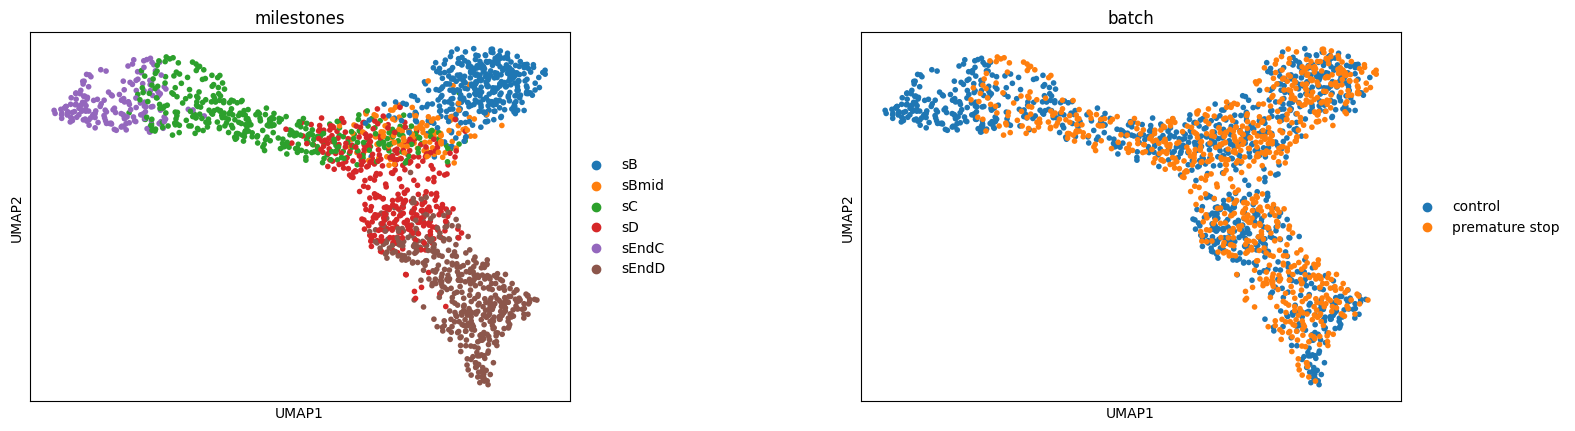

In [146]:
sc.pl.umap(corrected_adata_same, color=['milestones', 'batch'], wspace=0.4)

In [168]:
lin_cats = {
    "sB": "sB",
    "sBmid": "sBmid",
    "sC": "sC",
    "sEndC": "sC",
    "sD": "sD",
    "sEndD": "sD",
}

In [169]:
d2_lin = d2.copy()
d1_lin = d1.copy()


In [170]:
d2_lin.obs["milestones"] = d2_lin.obs.milestones.map(lin_cats).astype("category")
d1_lin.obs["milestones"] = d1_lin.obs.milestones.map(lin_cats).astype("category")

# d1_lin.obs["milestones"] = d1_lin.obs.milestones.cat.rename_categories({'sEndC': 'sC', 'sEndD': 'sD'})

In [171]:
dm_lin = {
    "control": d1_lin,
    "premature stop": d2_lin
}
dm_lin = ad.concat(dm_lin, label="batch")
dm_lin.obs_names_make_unique()
scgen.SCGEN.setup_anndata(dm_lin, batch_key="batch", labels_key="milestones")
model_lin = scgen.SCGEN(dm_lin)
model_lin.train(
    max_epochs=100,
    batch_size=16,
    early_stopping=True,
    early_stopping_patience=25,
)
corrected_adata_lin = model_lin.batch_removal()

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1553.998. Signaling Trainer to stop.
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/louise/Work/scgen/scgen/_scgen.py:265: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  batch_list[study].X = delta + batch_list[study].X
/home/louise/Work/scgen/scgen/_scgen.py:266: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
  temp_cell[batch_ind[study]].X = batch_list[study].X
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:602: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indice

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 531 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


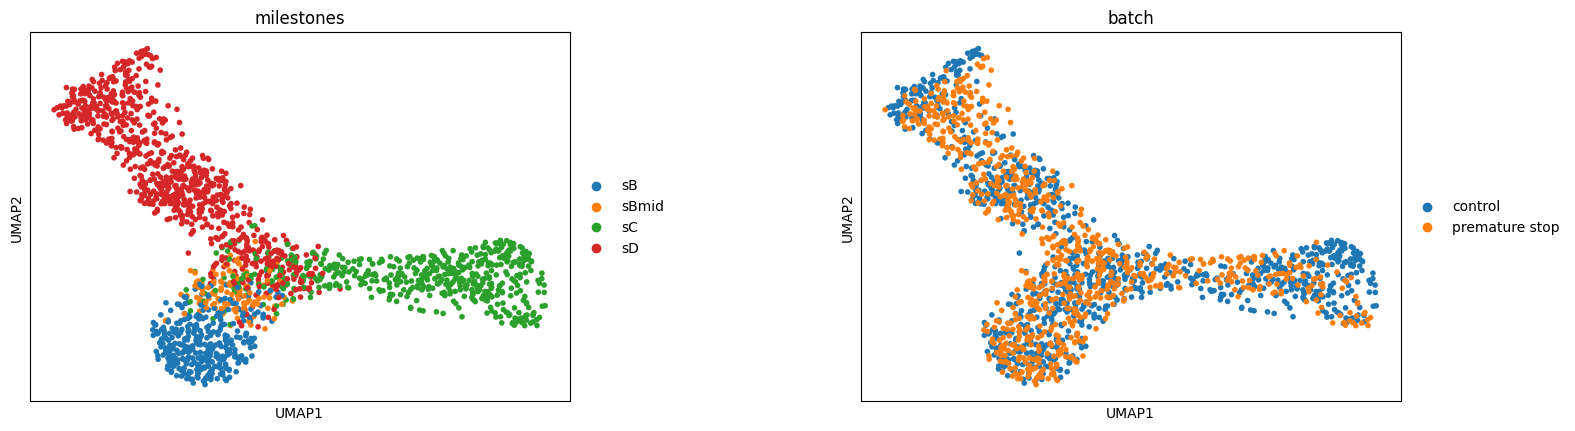

In [172]:
sc.pp.neighbors(corrected_adata_lin)
sc.tl.umap(corrected_adata_lin)
sc.pl.umap(corrected_adata_lin, color=['milestones', 'batch'], wspace=0.4)

<Axes: xlabel='x', ylabel='y'>

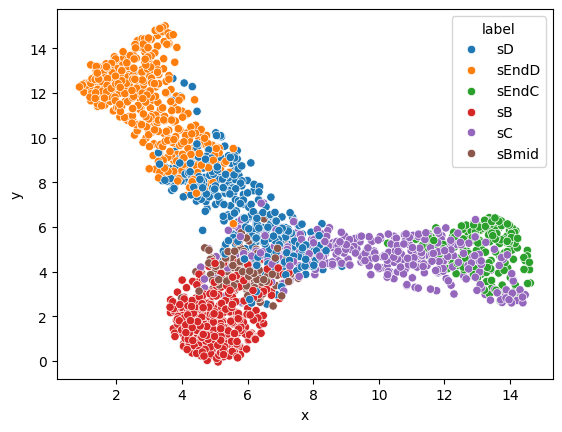

In [174]:
# xvals = np.concat((adatas_cor[0].obsm["X_scanorama"][:, 0] ,adatas_cor[1].obsm["X_scanorama"][:, 0]))
# yvals = np.concat((adatas_cor[0].obsm["X_scanorama"][:, 1] ,adatas_cor[1].obsm["X_scanorama"][:, 1]))
# cats = np.concat((adatas_cor[0].obs["milestones"].values ,adatas_cor[1].obs["milestones"].values))

xvals = corrected_adata_lin.obsm["X_umap"][:, 0]
yvals = corrected_adata_lin.obsm["X_umap"][:, 1]
cats = np.concat((d1.obs["milestones"].values ,d2.obs["milestones"].values))

# create a DataFrame for the legend
legend_df = pd.DataFrame({
    "x": xvals,
    "y": yvals,
    "label": cats,
})

sns.scatterplot(
    data=legend_df,
    x="x",
    y="y",
    hue="label",
    legend=True,
)

In [175]:
corrected_adata_lin

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'old_milestones', 'batch', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'pca', 'neighbors', 'umap', 'milestones_colors', 'batch_colors'
    obsm: 'latent', 'corrected_latent', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [176]:
sc.pp.neighbors(corrected_adata_lin, use_rep="latent")

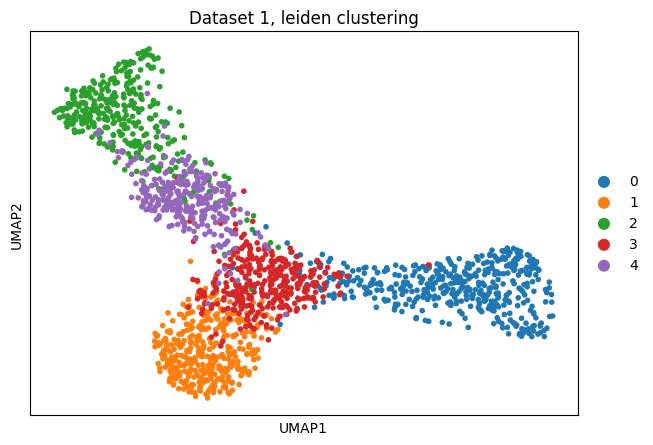

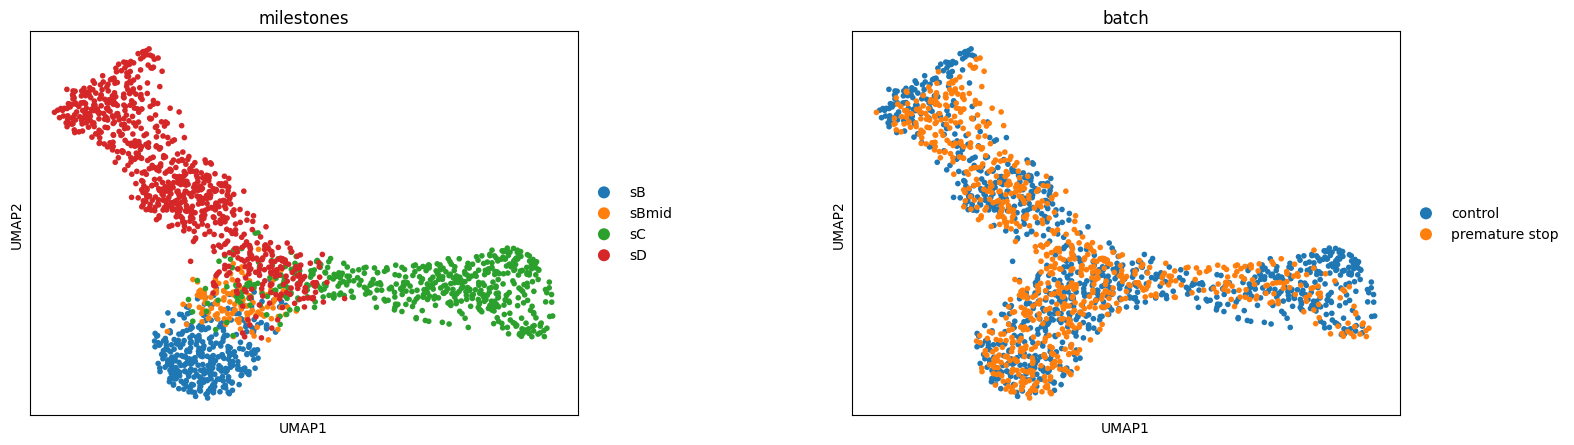

In [177]:
sc.tl.leiden(corrected_adata_lin, resolution=1.3, key_added="leiden1.3")
sc.pl.scatter(corrected_adata_lin, basis="umap", color='leiden1.3', title="Dataset 1, leiden clustering")
sc.pl.scatter(corrected_adata_lin, basis="umap", color=['milestones', 'batch'])

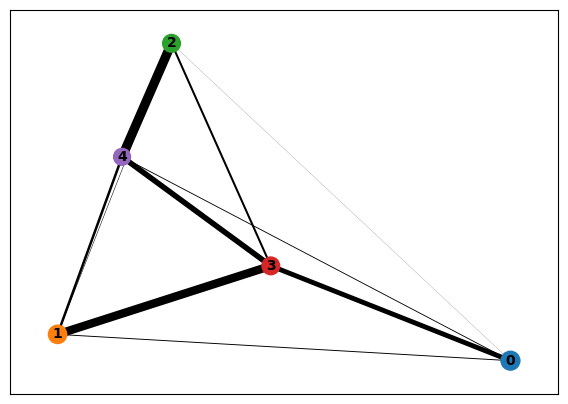

In [178]:
sc.tl.paga(corrected_adata_lin, groups="leiden1.3")
sc.pl.paga(corrected_adata_lin)

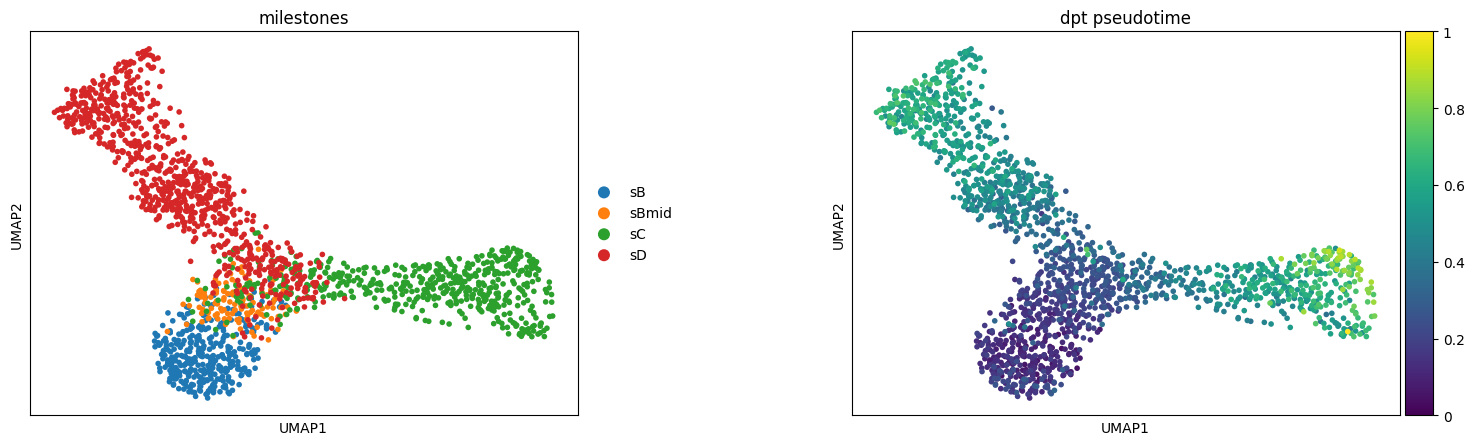

In [179]:
corrected_adata_lin.uns["iroot"] = np.flatnonzero(corrected_adata_lin.obs["sim_time"] == 0.0)[0]
sc.tl.dpt(corrected_adata_lin)
sc.pl.scatter(corrected_adata_lin, basis="umap", color=["milestones", "dpt_pseudotime"])

In [180]:
# split into 2, 6, 1, 0, 5
scgen_l2_1 = corrected_adata_lin[corrected_adata_lin.obs["leiden1.3"].isin(["2", "3", "5", "0"])]
# split into 2, 6, 1, 4, 3
scgen_l2 = corrected_adata_lin[corrected_adata_lin.obs["leiden1.3"].isin(["2", "3", "1", "4"])]

In [181]:
scgen_l2_1.obs

step_ix  simulation_i    sim_time milestones leiden  \
cell1          4972            62  150.083333         sD      0   
cell2          7919            98  460.083333         sD      4   
cell3            54             1  380.083333         sD      4   
cell4          2870            36  190.000000         sD      0   
cell5          4848            60  530.083333         sC      5   
...             ...           ...         ...        ...    ...   
cell990-1      6184            77  120.083333         sD      0   
cell991-1      4495            56  240.000000         sC      4   
cell996-1      2138            27  160.000000         sC      0   
cell998-1      2065            26  240.000000         sD      0   
cell1000-1     3201            40  260.000000         sC      4   

            dpt_pseudotime old_milestones           batch  _scvi_batch  \
cell1             0.328501             sD         control            0   
cell2             0.497605             sD         control            0   
cell3             0.539618          sEndD         control            0   
cell4             0.233788             sD         control            0   
cell5             0.789775          sEndC         control            0   
...                    ...            ...             ...          ...   
cell990-1         0.243195             sD  premature stop            1   
cell991-1         0.500784             sC  premature stop            1   
cell996-1         0.494340             sC  premature stop            1   
cell998-1         0.130527             sD  premature stop            1   
cell1000-1        0.481353             sC  premature stop            1   

            _scvi_labels leiden1.3  
cell1                  3         3  
cell2                  3         2  
cell3                  3         2  
cell4                  3         3  
cell5                  2         0  
...                  ...       ...  
cell990-1              3         3  
cell991-1              2         0  
cell996-1              2         0  
cell998-1              3         3  
cell1000-1             2         0  

[1139 rows x 11 columns]

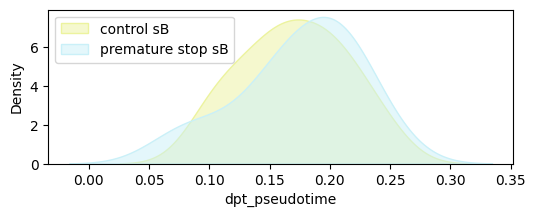

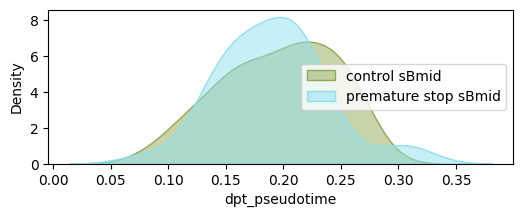

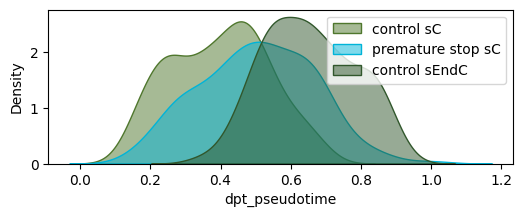

In [214]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(scgen_l2_1, "sB", colors = ["#ecf39e", "#caf0f8"])
    comp_kde(scgen_l2_1, "sBmid", colors = ["#90a955", "#90e0ef"])
    
    kdeplot2(scgen_l2_1, "control", "sC", milestone_column = "old_milestones", color="#4f772d")
    kdeplot2(scgen_l2_1, "premature stop", "sC", milestone_column = "old_milestones", color="#00b4d8")
    kdeplot2(scgen_l2_1, "control", "sEndC", milestone_column = "old_milestones", color="#31572c")
    plt.legend()


## fastMNN

In [18]:
fastmnn = ad.concat([d1, d2], label="batch")
fastmnn.obs_names_make_unique()

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [95]:
fastmnn.obs.batch

cell1         0
cell2         0
cell3         0
cell4         0
cell5         0
             ..
cell996-1     1
cell997-1     1
cell998-1     1
cell999-1     1
cell1000-1    1
Name: batch, Length: 1822, dtype: category
Categories (2, object): ['0', '1']

In [96]:
fastmnn.write("data/fastmnn.h5ad")

In [215]:
fastmnn_result = ad.read_h5ad("data/fastmnn_result.h5ad")

In [216]:
fastmnn_result

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'batch'
    obsm: 'corrected'

In [217]:
fastmnn_result.obsm["corrected"].shape

(1822, 50)

In [225]:
fastmnn_result.obs["sim_time"] = np.append(d1.obs["sim_time"], d2.obs["sim_time"])

In [226]:
fastmnn_result.obs["sim_time"]

1       150.083333
2       460.083333
3       380.083333
4       190.000000
5       530.083333
           ...    
1818    160.000000
1819    380.083333
1820    240.000000
1821    130.083333
1822    260.000000
Name: sim_time, Length: 1822, dtype: float64

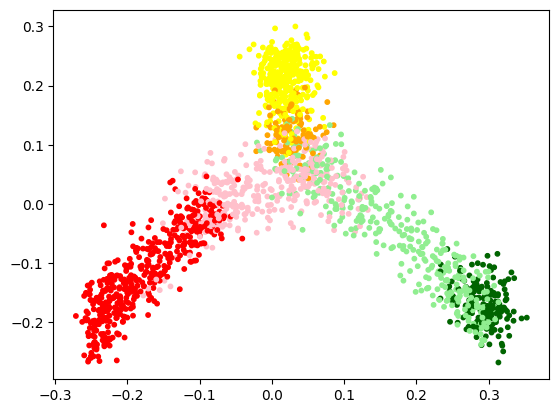

In [218]:
xs = fastmnn_result.obsm["corrected"][:, 0]
ys = fastmnn_result.obsm["corrected"][:, 1]
cats = np.concat((d1.obs["milestones"].values ,d2.obs["milestones"].values))

colors = {
    "sB": "yellow",
    "sBmid": "orange",
    "sC": "lightgreen",
    "sC_batch": "purple",
    "sEndC": "darkgreen",
    "sD": "pink",
    "sEndD": "red",
}

cats = [colors[cat] for cat in cats]

plt.scatter(xs, ys, c=cats, s=10)

In [219]:
fastmnn_result.obs["milestones"] = fastmnn.obs["milestones"].values

In [220]:
fastmnn_result.obsm["X_corrected"] = fastmnn_result.obsm["corrected"]

In [221]:
fastmnn.obs["milestones"].values

['sD', 'sD', 'sEndD', 'sD', 'sEndC', ..., 'sC_batch', 'sEndD', 'sD', 'sD', 'sC_batch']
Length: 1822
Categories (7, object): ['sB', 'sBmid', 'sC', 'sC_batch', 'sD', 'sEndC', 'sEndD']

In [59]:
d1.uns["iroot"]

np.int64(6)

In [227]:
fastmnn_result.uns["iroot"] = np.flatnonzero(fastmnn_result.obs["sim_time"] == 0.0)[0]


In [ ]:
# d1.uns["iroot"] = np.flatnonzero(d1.obs_names == d1.uns["iroot"])[0]

In [228]:
fastmnn_result.obs_names

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1813', '1814', '1815', '1816', '1817', '1818', '1819', '1820', '1821',
       '1822'],
      dtype='object', length=1822)

In [60]:
fastmnn_result.uns["iroot"] = d1.uns["iroot"]

In [230]:
# fastmnn_result.uns["iroot"] = np.flatnonzero(fastmnn_result.obs["milestones"] == "sB")[0]
sc.pp.neighbors(fastmnn_result, use_rep="corrected")

In [62]:
fastmnn_result.uns["iroot"]

np.int64(6)

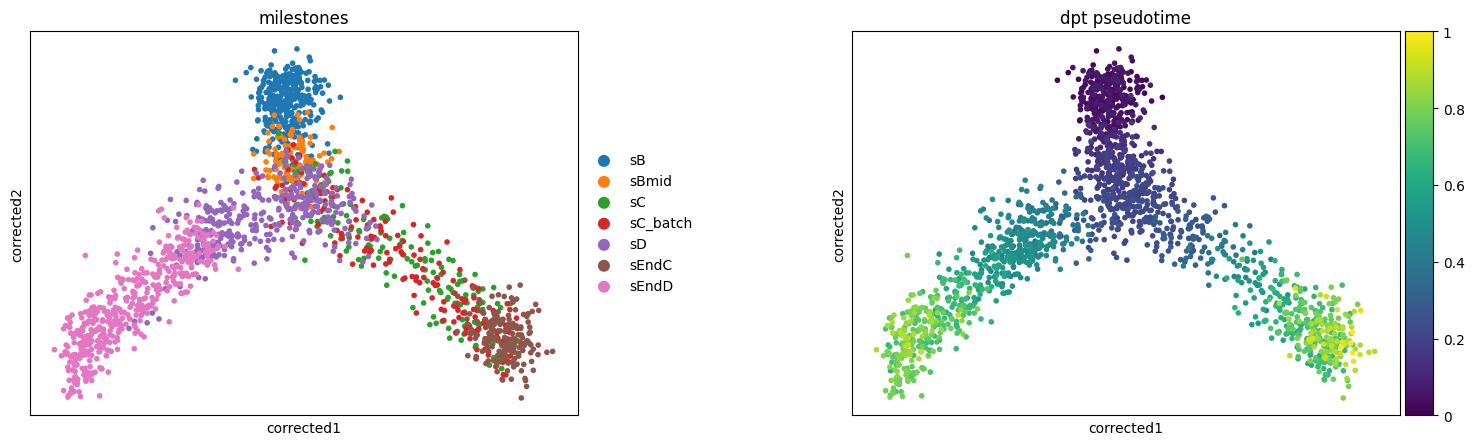

In [232]:
sc.tl.dpt(fastmnn_result)
sc.pl.scatter(fastmnn_result, basis="corrected", color=["milestones", "dpt_pseudotime"])

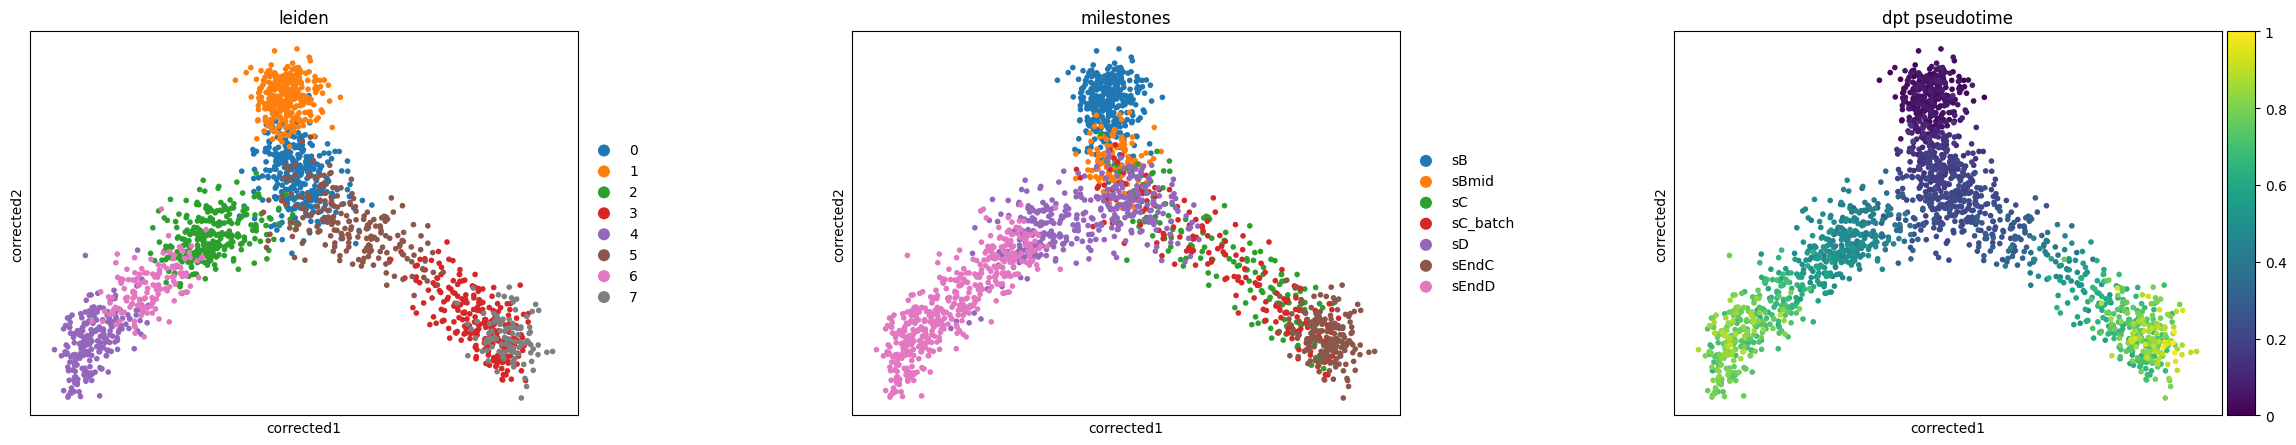

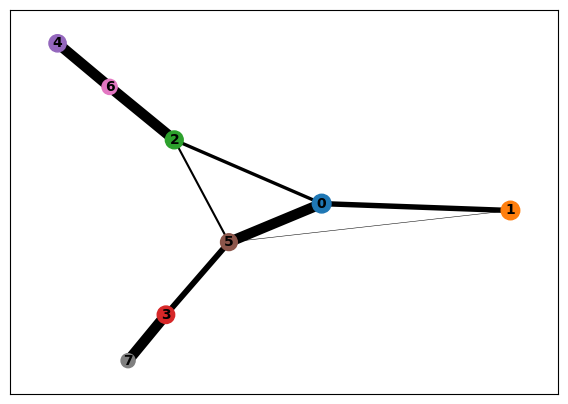

In [233]:
sc.tl.leiden(fastmnn_result, resolution=1.75, key_added="leiden")
sc.pl.scatter(fastmnn_result, basis="corrected", color=['leiden', 'milestones', 'dpt_pseudotime'])
sc.tl.paga(fastmnn_result, groups="leiden")
sc.pl.paga(fastmnn_result)

In [234]:
# split into 1, 0, 5, 3, 7
fastmnn_l1 = fastmnn_result[fastmnn_result.obs["leiden"].isin(["1", "0", "5", "3", "7"])]
# split into 1, 0, 2, 6, 4
fastmnn_l2 = fastmnn_result[fastmnn_result.obs["leiden"].isin(["1", "0", "2", "6", "4"])]

In [235]:
fastmnn_l1.obs

batch milestones    sim_time  dpt_pseudotime leiden
1         1         sD  150.083333        0.246579      5
4         1         sD  190.000000        0.219052      0
5         1      sEndC  530.083333        0.982908      7
6         1      sEndC  440.083333        0.782351      7
7         1         sB   90.083333        0.143413      0
...     ...        ...         ...             ...    ...
1815      2         sB   70.000000        0.069760      1
1818      2   sC_batch  160.000000        0.294969      5
1820      2         sD  240.000000        0.141136      0
1821      2         sD  130.083333        0.137187      0
1822      2   sC_batch  260.000000        0.646067      3

[1187 rows x 5 columns]

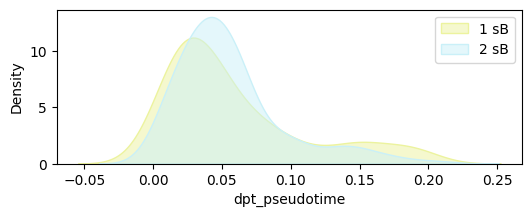

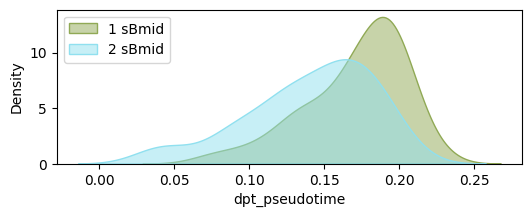

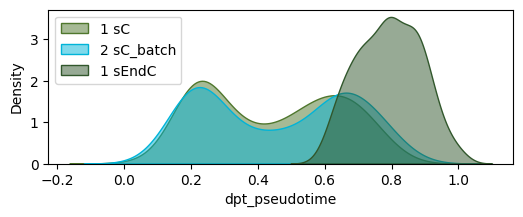

In [240]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(fastmnn_l1, "sB", batches = [1, 2], colors = ["#ecf39e", "#caf0f8"])
    comp_kde(fastmnn_l1, "sBmid", batches = [1, 2], colors = ["#90a955", "#90e0ef"])
    
    kdeplot2(fastmnn_l1, 1, "sC", milestone_column = "milestones", color="#4f772d")
    kdeplot2(fastmnn_l1, 2, "sC_batch", milestone_column = "milestones", color="#00b4d8")
    kdeplot2(fastmnn_l1, 1, "sEndC", milestone_column = "milestones", color="#31572c")
    plt.legend()


<Axes: xlabel='dpt_pseudotime', ylabel='Density'>

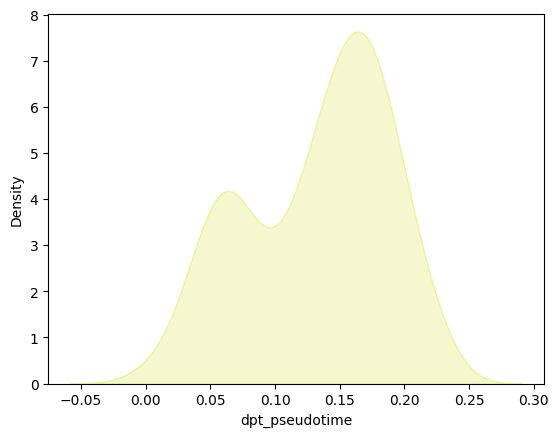

In [47]:
batch = 1
milestone = "sB"
color = "#ecf39e"
adata_mst = fastmnn_l1[fastmnn_l1.obs["milestones"] == milestone]
adata_btc = adata_mst[adata_mst.obs["batch"] == batch]

sns.kdeplot(adata_btc.obs["dpt_pseudotime"], label=f"{batch} {milestone}", fill=True, alpha=0.5, color= color)

In [46]:
adata_mst.obs["batch"]

7       1
12      1
13      1
15      1
16      1
       ..
1800    2
1802    2
1805    2
1812    2
1815    2
Name: batch, Length: 360, dtype: int32

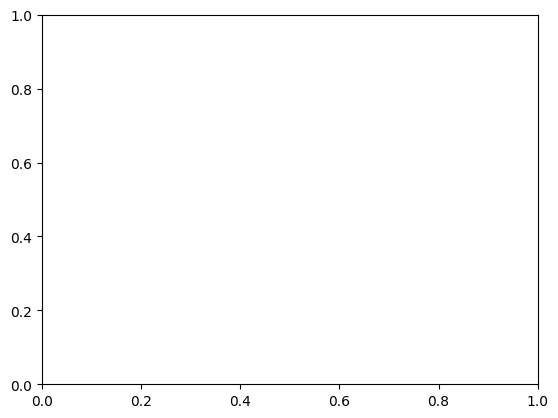

In [41]:
kdeplot(fastmnn_l1, "1", "sB", color= "#ecf39e")

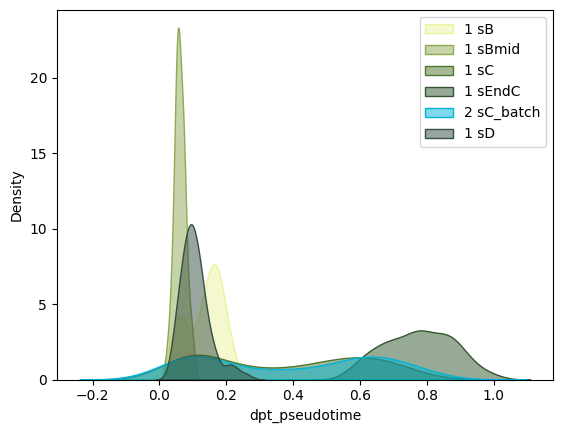

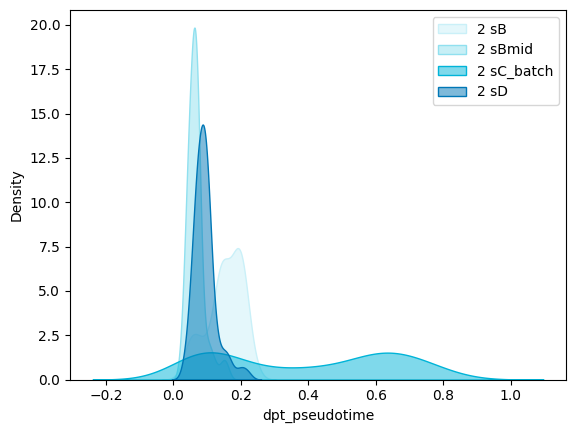

In [50]:
kdeplot(fastmnn_l1, 1, "sB", color= "#ecf39e")
kdeplot(fastmnn_l1, 1, "sBmid", color="#90a955")
kdeplot(fastmnn_l1, 1, "sC", color="#4f772d")
kdeplot(fastmnn_l1, 1, "sEndC", color="#31572c")
kdeplot(fastmnn_l1, 2, "sC_batch", color="#00b4d8")
kdeplot(fastmnn_l1, 1, "sD", color="#344e41")
plt.legend()
plt.figure()
kdeplot(fastmnn_l1, 2, "sB", color= "#caf0f8")
kdeplot(fastmnn_l1, 2, "sBmid", color="#90e0ef")
kdeplot(fastmnn_l1, 2, "sC", color="#00b4d8")
kdeplot(fastmnn_l1, 2, "sC_batch", color="#00b4d8")
kdeplot(fastmnn_l1, 2, "sD", color="#0077b6")
plt.legend()

In [6]:
sc.pl.scatter(fastmnn_result, basis="corrected", color='milestones', title="Dataset 1, fastmnn clustering")

KeyError: 'compute coordinates using visualization tool corrected first'

The scib paper seems to use an implementation in Python for mnn and not fastMNN. cf: https://github.com/theislab/scib/blob/main/scib/integration.py

In [25]:
import mnnpy

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/mnnpy/utils.py:30: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  dist[i, j] = np.dot(m[i], n[j])
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/mnnpy/utils.py:205: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'C', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  scale = np.dot(working, grad)
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/mnnpy/utils.py:215: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'C', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  curproj = np.dot(grad, curcell)


In [67]:
mnn1 = ad.AnnData(X=d1.X, obs=d1.obs, var=d1.var)
mnn2 = ad.AnnData(X=d2.X, obs=d2.obs, var=d2.var)

In [69]:
mnn1

AnnData object with n_obs × n_vars = 1000 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'mean', 'std'

In [70]:
mnn2

AnnData object with n_obs × n_vars = 822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime'
    var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'mean', 'std'

In [72]:
corrected_adata, pairinginfo, angles = mnnpy.mnn_correct(
    mnn1, mnn2,
    batch_key="mnn_batch",
    do_concatenate=False
)

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


In [73]:
corrected_adata

(AnnData object with n_obs × n_vars = 1000 × 531
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'mean', 'std',
 AnnData object with n_obs × n_vars = 822 × 531
     obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime'
     var: 'module_id', 'basal', 'burn', 'independence', 'color', 'is_tf', 'is_hk', 'transcription_rate', 'splicing_rate', 'translation_rate', 'mrna_halflife', 'protein_halflife', 'mrna_decay_rate', 'protein_decay_rate', 'max_premrna', 'max_mrna', 'max_protein', 'mol_premrna', 'mol_mrna', 'mol_protein', 'mean', 'std')

In [74]:
adatas_corrected = ad.concat(
    {"control": corrected_adata[0], "premature stop": corrected_adata[1]},
    label="batch",
    uns_merge="unique",
    index_unique="-",
)

In [75]:
adatas_corrected

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'batch'

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 531 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


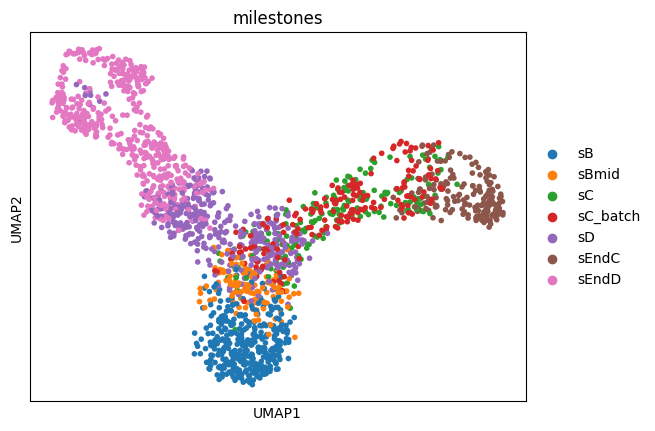

In [77]:
sc.pp.neighbors(adatas_corrected)
sc.tl.umap(adatas_corrected)
sc.pl.umap(adatas_corrected, color='milestones')

## dynchro

### prep datasets (leiden, paga, lineages)

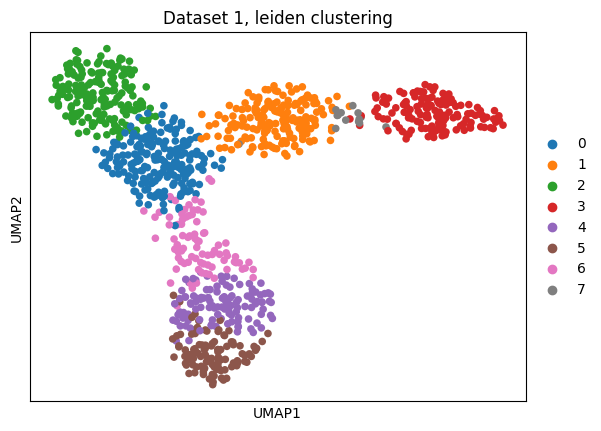

In [135]:
sc.tl.leiden(d1, resolution=1.75, key_added="leiden1.75")
sc.pl.umap(d1, color='leiden1.75', title="Dataset 1, leiden clustering")

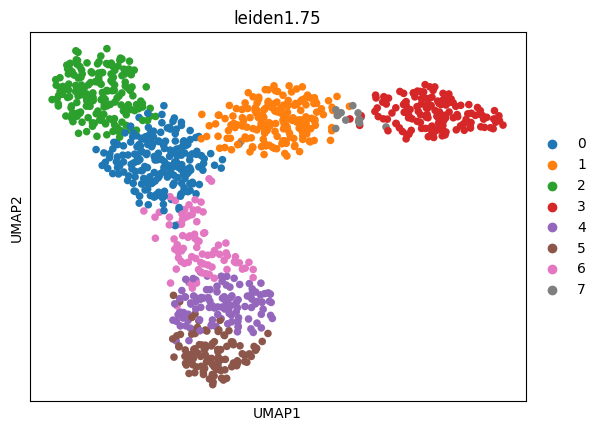

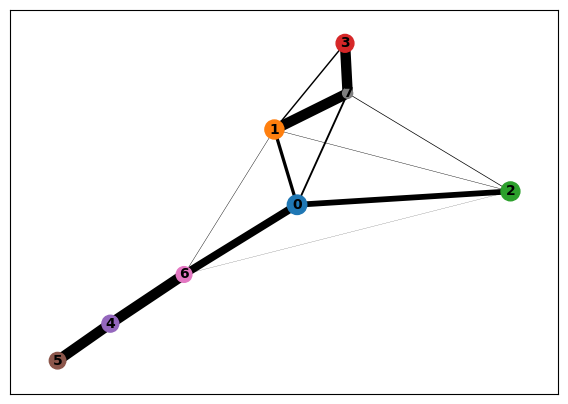

In [136]:
sc.tl.paga(d1, groups="leiden1.75")
sc.pl.umap(d1, color="leiden1.75")
sc.pl.paga(d1)

In [137]:
# select 2, 0, 6, 4, 5 from "leiden1.75"
d1_lin1 = d1[d1.obs["leiden1.75"].isin(["2", "0", "6", "4", "5"])]

# select 2, 0, 1, 7, 3 from "leiden1.75"
d1_lin2 = d1[d1.obs["leiden1.75"].isin(["2", "0", "1", "7", "3"])]

In [138]:
sc.tl.leiden(d2, resolution=1.5, key_added="leiden1.75")

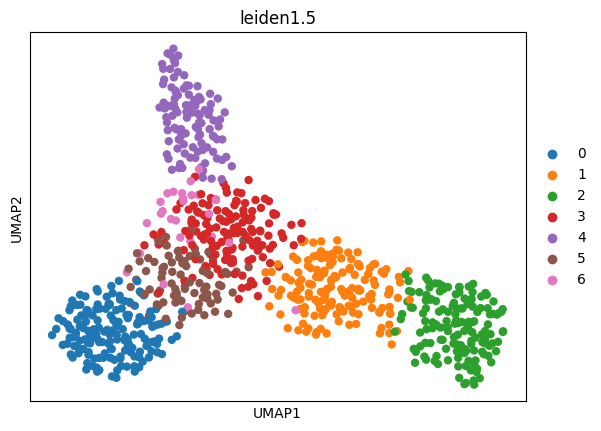

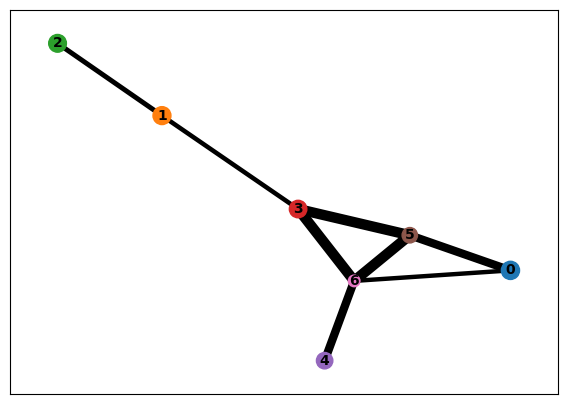

In [139]:
sc.tl.paga(d2, groups="leiden1.5")
sc.pl.umap(d2, color="leiden1.5")
sc.pl.paga(d2, threshold=0.4)

In [140]:
# select 0, 5, 6, 4 from "leiden1.5"
d2_lin1 = d2[d2.obs["leiden1.5"].isin(["0", "5", "6", "4"])]

# select 0, 5, 3, 1, 2 from "leiden1.5"
d2_lin2 = d2[d2.obs["leiden1.5"].isin(["0", "5", "3", "1", "2"])]

### get counts and sort

In [144]:
counts_d1lC = d1_lin1.X.toarray()
counts_d1lD = d1_lin2.X.toarray()
counts_d2lC = d2_lin1.X.toarray()
counts_d2lD = d2_lin2.X.toarray()

In [146]:
counts_d1lC = counts_d1lC[np.argsort(d1_lin1.obs["dpt_pseudotime"].values), :]
counts_d1lD = counts_d1lD[np.argsort(d1_lin2.obs["dpt_pseudotime"].values), :]
counts_d2lC = counts_d2lC[np.argsort(d2_lin1.obs["dpt_pseudotime"].values), :]
counts_d2lD = counts_d2lD[np.argsort(d2_lin2.obs["dpt_pseudotime"].values), :]

In [150]:
def run_dtw(counts1, counts2):
    """
    Run DTW on two datasets
    """
    total, cost, distances = skip_dtw(counts1, counts2)
    path = skip_traceback(distances)

    sns.heatmap(cost, cmap="crest")
    plt.figure()
    sns.heatmap(distances[1:, 1:], cmap="crest")
    sns.lineplot(x=path[0], y=path[1], color="red", linewidth=1)
    plt.title(f"DTW, total cost: {total}")
    plt.show()

    

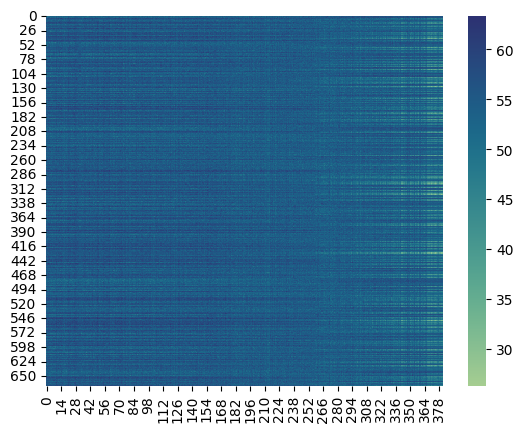

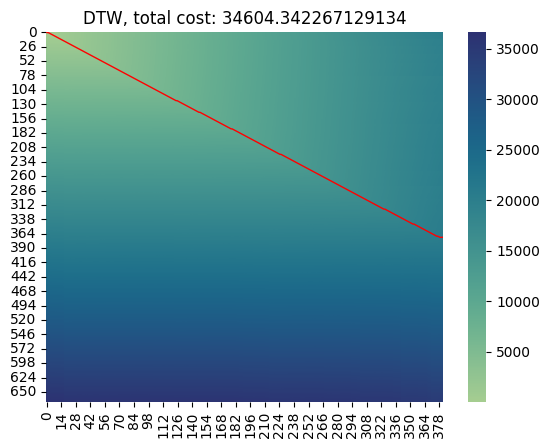

In [155]:
dtw_resultcc = run_dtw(counts_d1lC, counts_d2lC)

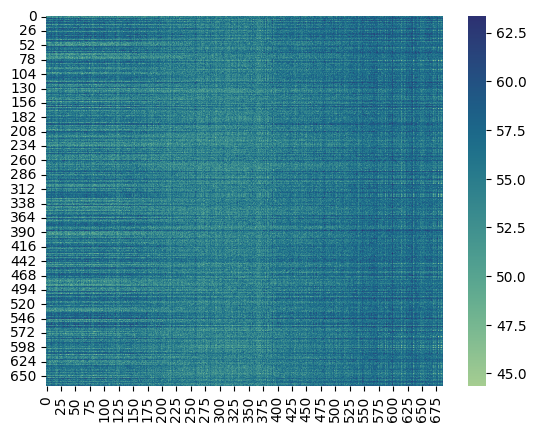

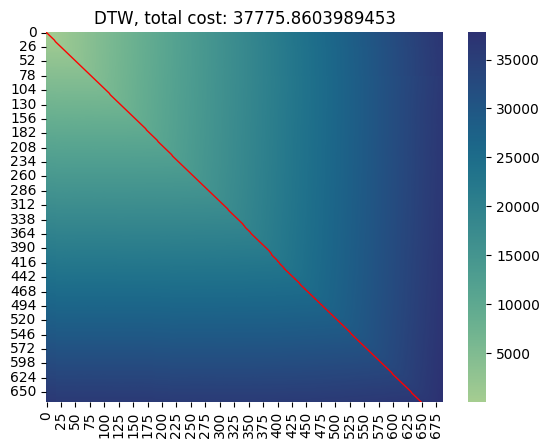

In [156]:
dtw_resultcd = run_dtw(counts_d1lC, counts_d2lD)

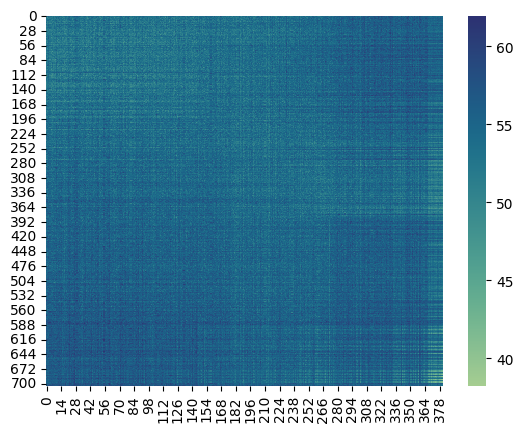

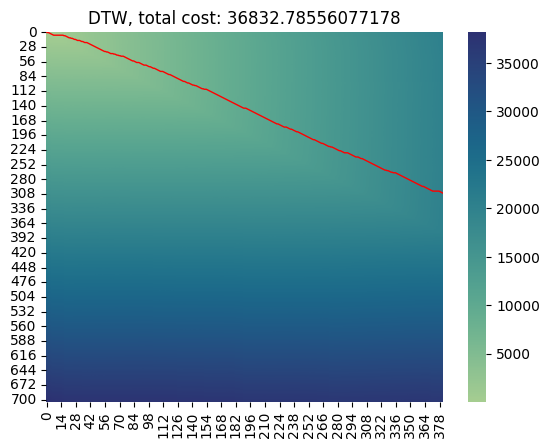

In [157]:
dtw_resultdc = run_dtw(counts_d1lD, counts_d2lC)

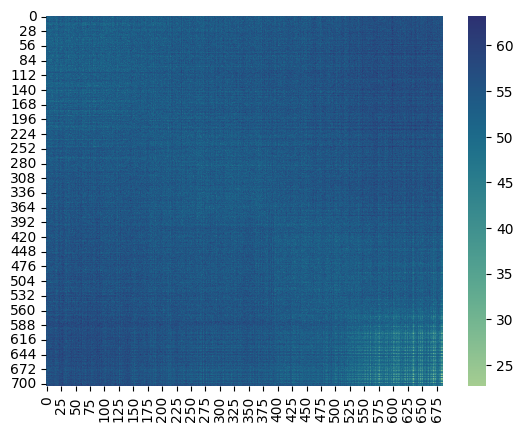

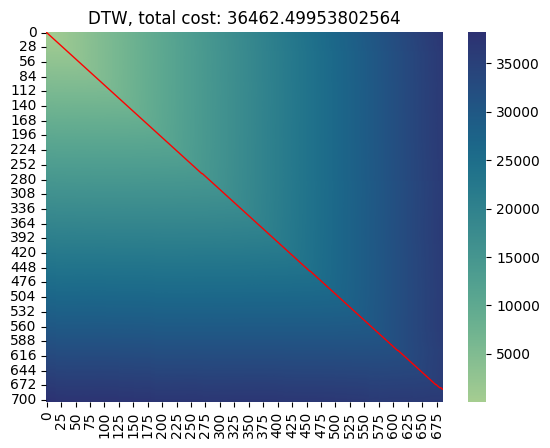

In [158]:
dtw_resultdd = run_dtw(counts_d1lD, counts_d2lD)

### kde plots

In [ ]:
import pandas as pd


In [167]:
def select_milestone(adata, milestone):
    """
    Select a milestone from the dataset
    """
    return adata[adata.obs["milestones"] == milestone].copy()

def prep_milestone_plot(adata, milestone):
    """
    Prepare a milestone plot
    """
    adata_milestone = select_milestone(adata, milestone)
    return adata_milestone.obs["dpt_pseudotime"]

<Axes: xlabel='dpt_pseudotime', ylabel='Density'>

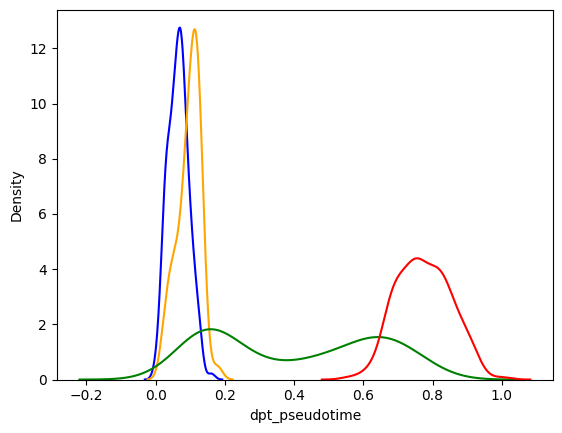

In [171]:
sns.kdeplot(prep_milestone_plot(d1_lin1, "sB"), label="sB", color="blue")
sns.kdeplot(prep_milestone_plot(d1_lin1, "sBmid"), label="sBmid", color="orange")
sns.kdeplot(prep_milestone_plot(d1_lin1, "sC"), label="sC", color="green")
sns.kdeplot(prep_milestone_plot(d1_lin1, "sEndC"), label="sEndC", color="red")

<Axes: xlabel='dpt_pseudotime', ylabel='Density'>

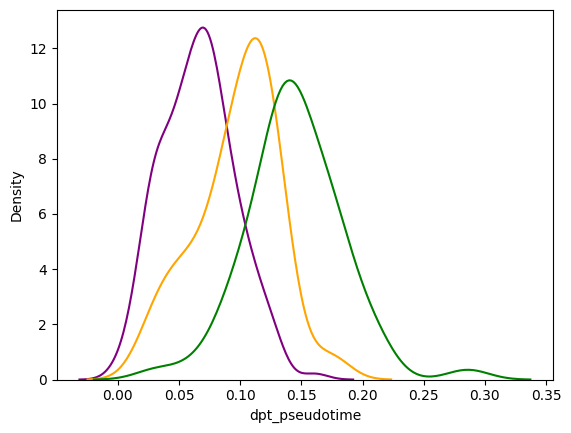

In [ ]:
sns.kdeplot(prep_milestone_plot(d1_lin2, "sB"), label="sD", color="purple")
sns.kdeplot(prep_milestone_plot(d1_lin2, "sBmid"), label="sBmid", color="orange")
sns.kdeplot(prep_milestone_plot(d1_lin2, "sC"), label="sC", color="green")

<Axes: xlabel='dpt_pseudotime', ylabel='Density'>

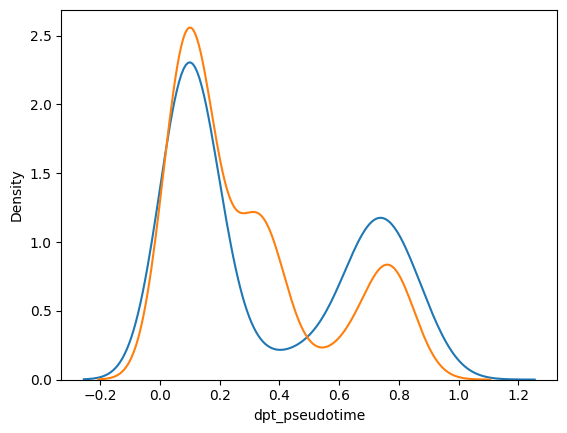

In [166]:
sns.kdeplot(d1_lin1.obs["dpt_pseudotime"], label = "control")
sns.kdeplot(d1_lin2.obs["dpt_pseudotime"], label = "batch")

In [161]:
d1_lin1.obs["dpt_pseudotime"]

cell1       0.183115
cell4       0.143597
cell5       0.933513
cell6       0.773460
cell7       0.000000
              ...   
cell995     0.684300
cell996     0.071835
cell997     0.723212
cell998     0.691167
cell1000    0.032732
Name: dpt_pseudotime, Length: 668, dtype: float32